<a id='intro'></a>
# LaLiga Data: 

> I have selected the Soccer Database from Kaggel, I have 2 topics to analyze: The Standing table of season 2014/2015 and the Sum of all the goals during the season between 2008 and 2016  

Data Source: https://www.kaggle.com/hugomathien/soccer

# Questions to investigate: 

> ### 1. Who has the highest points and goal differences during the seasn 2014/2015? 
> ### 2. During the seasons 2008-2016 who scored the most goals and had good defense players? 

### Importing the libraries:

In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

import pandas as pd 
import numpy as np 
import sqlite3 as sq
import matplotlib.pyplot as plt 
%matplotlib inline 


### Laod the data:

In [2]:
# https://www.dataquest.io/blog/python-pandas-databases/
#  read the data from SQL database and load it 

# connect python to the database 
con = sq.connect('database.sqlite')

# read and load the data from the database from different tablas inside 
leagues = pd.read_sql('select * from league', con)
match   = pd.read_sql('select * from match', con)
player  = pd.read_sql('select * from player', con)
team    = pd.read_sql('select * from team', con)


#### Initate the dataframe:

In [3]:
# https://towardsdatascience.com/pandas-tips-and-tricks-33bcc8a40bb9
# intiate a dataframe for only LaLiga league  
laliga = match.loc[match['country_id'] == 21518] 

# group the data by seasons 
laliga.groupby('season')['season'].value_counts() 

season     season   
2008/2009  2008/2009    380
2009/2010  2009/2010    380
2010/2011  2010/2011    380
2011/2012  2011/2012    380
2012/2013  2012/2013    380
2013/2014  2013/2014    380
2014/2015  2014/2015    380
2015/2016  2015/2016    380
Name: season, dtype: int64

## I chose first to analyze a specific season (2014/2015): 
### Standing table (Points and Goal Differences for the season) 

In [4]:
# Intiate a new dataframe for the matches during the season 2014/2015 
laliga_season = match.loc[(match['country_id'] == 21518) & (match['season'] == '2014/2015')] 
# dataframe for the matches during 2008 to 2016 (full database): 
laliga_season_all = match.loc[(match['country_id'] == 21518)] 

# season teams group by: 
laliga_season_teams = laliga_season.groupby(['home_team_api_id']) 
laliga_season_teams_all = laliga_season_all.groupby(['home_team_api_id']) 

In [5]:
# intiate dictionary for the standing 
standing = {}

# function to add match score to standing dict
# it takes: - ht: home team name.
#           - at: away team name.
#           - hgf: home team goals.
#           - agf: away team goals.
#           - hw: True if home team win.
#           - aw: True if away team win.
#           - d: True if draw.
def add_score(ht, at, hgf, agf, hw, aw, d): 

# if the home team wins the value from the for loop returns here 
    if hw:
        standing[ht]['Pts'] += 3
        standing[ht]['GF'] += hgf
        standing[at]['GF'] += agf
        standing[ht]['GA'] += agf
        standing[at]['GA'] += hgf
        standing[at]['L'] += 1
        standing[ht]['W'] += 1 

#if the away team wins the value from the for loop returns here 
    if aw:
        standing[at]['Pts'] += 3
        standing[ht]['GF'] += hgf
        standing[at]['GF'] += agf
        standing[ht]['GA'] += agf
        standing[at]['GA'] += hgf
        standing[at]['W'] += 1
        standing[ht]['L'] += 1
        
# if they both draw the value from the for loop returns here 
    if d:
        standing[ht]['Pts'] += 1
        standing[at]['Pts'] += 1
        standing[ht]['GF'] += hgf
        standing[at]['GF'] += agf
        standing[ht]['GA'] += agf
        standing[at]['GA'] += hgf
        standing[at]['D'] += 1
        standing[ht]['D'] += 1

In [6]:
# https://stackoverflow.com/questions/42513049/get-all-keys-from-groupby-object-in-pandas
# add teams to standing dictionary 
# loop over teams and add names to standing dictionary 
for key in laliga_season_teams.groups.keys():
    teams = team['team_long_name'].loc[team['team_api_id'] == key] # teams name 
# intiate dictionary for each team in laliga 
    standing[teams.item()] = {'Pts': 0,
                             'W': 0,
                             'D': 0,
                             'L': 0,
                             'GF': 0,
                             'GA': 0,
                             'GD': 0
                            }

In [7]:
# https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
# for loop to determine the points and the goals 
for index, row in laliga_season.iterrows():
    home_team = team['team_long_name'].loc[team['team_api_id'] == row.home_team_api_id].item() #gets the home team name
    away_team = team['team_long_name'].loc[team['team_api_id'] == row.away_team_api_id].item() #gets the away team name
# if condition for the results from the matches they played and it returns to the function     
    if row.home_team_goal == row.away_team_goal:
        add_score(home_team, away_team, row.home_team_goal, row.away_team_goal, False, False, True)
    elif row.home_team_goal > row.away_team_goal:
        add_score(home_team, away_team, row.home_team_goal, row.away_team_goal, True, False, False)
    else:
        add_score(home_team, away_team, row.home_team_goal, row.away_team_goal, False, True, False)

In [8]:
# https://stackoverflow.com/questions/42869544/dictionary-of-lists-to-dataframe 
# convert python dictionary to pandas df 
standing_df = pd.DataFrame.from_dict(standing,orient='index')

In [9]:
# https://stackoverflow.com/questions/34023918/make-new-column-in-panda-dataframe-by-adding-values-from-other-columns/34023971
# calculating the goal difference and how many matches each team played 
standing_df['GD'] = standing_df['GF'] - standing_df['GA']
standing_df['MP'] = standing_df['W'] + standing_df['D'] + standing_df['L']

Desplaying the datafram into a Standing schedule 

In [10]:
# reorder pandas dataframe: https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns
# sort values by points: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
standing_df = standing_df[['MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts']].sort_values(by=['Pts', 'GD'], ascending=False)
# print the dataframe as a table (standing teams)
standing_df

,MP,W,D,L,GF,GA,GD,Pts
FC Barcelona,38,30,4,4,110,21,89,94
Real Madrid CF,38,30,2,6,118,38,80,92
Atlético Madrid,38,23,9,6,67,29,38,78
Valencia CF,38,22,11,5,70,32,38,77
Sevilla FC,38,23,7,8,71,45,26,76
Villarreal CF,38,16,12,10,48,37,11,60
Athletic Club de Bilbao,38,15,10,13,42,41,1,55
RC Celta de Vigo,38,13,12,13,47,44,3,51
Málaga CF,38,14,8,16,42,48,-6,50
RCD Espanyol,38,13,10,15,47,51,-4,49


## Analyzing the data: 

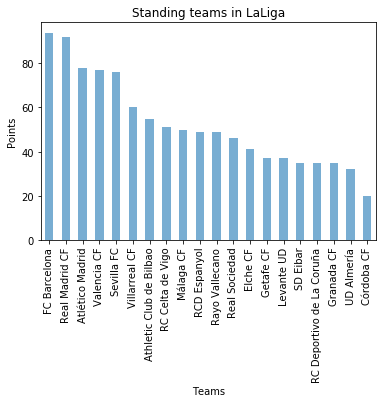

In [11]:
# plot a bar chart 
std_top = standing_df
std_top['Pts'].plot.bar(alpha=0.6) 
plt.title('Standing teams in LaLiga')
plt.xlabel('Teams')
plt.ylabel('Points'); 

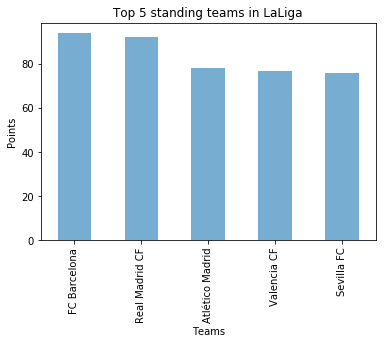

In [12]:
# plot a bar chart 
std_top = standing_df.head()
std_top['Pts'].plot.bar(alpha=0.6) 
plt.title('Top 5 standing teams in LaLiga')
plt.xlabel('Teams')
plt.ylabel('Points'); 

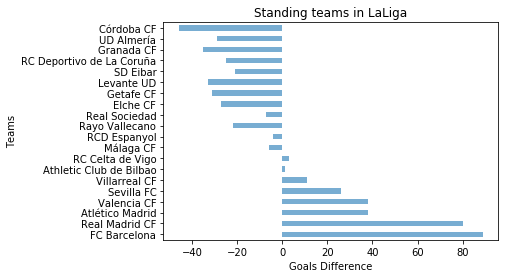

In [13]:
# plot a barh chart 
std_top = standing_df
std_top['GD'].plot.barh(alpha=0.6) 
plt.title('Standing teams in LaLiga')
plt.xlabel('Goals Difference')
plt.ylabel('Teams');

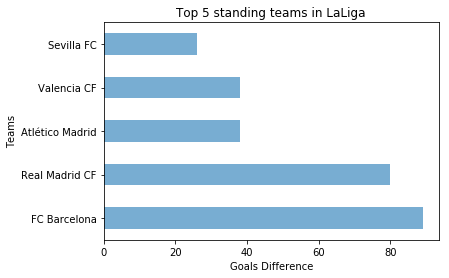

In [14]:
# plot a barh chart 
std_top = standing_df.head()
std_top['GD'].plot.barh(alpha=0.6) 
plt.title('Top 5 standing teams in LaLiga')
plt.xlabel('Goals Difference')
plt.ylabel('Teams');

### As we can see from the two charts above, FC Barcelona is on the top of both; points and goals differences. However, Real Madrid is right after it with slightly less points which means they had a tough competition between each other. Also we can see that Atletico Madrid, Valencia and Sevilla come after the big two rivals. Since FCB and RM have way many goals than the other football clubs with a ratio of 2:1 goals.



## Analyze the data from (2008-2016): 
### Goal differences 

In [15]:
# Intiate a new dataframe for the matches during all seasons (2008-2016)
laliga_season_all = match.loc[(match['country_id'] == 21518)]
# group by the home team id 
laliga_season_teams_all = laliga_season_all.groupby(['home_team_api_id'])

In [16]:
# intiate dictionary for the goals  
goals = {}

# function to add match score to standing dict
# it takes: - ht: home team name.
#           - at: away team name.
#           - hgf: home team goals.
#           - agf: away team goals.
#           - hw: True if home team win.
#           - aw: True if away team win.
#           - d: True if draw.
def add_goals(ht, at, hgf, agf, hw, aw, d):
    
# if the home team wins the value from the for loop returns here 
    if hw:
        goals[ht]['GF'] += hgf
        goals[at]['GF'] += agf
        goals[ht]['GA'] += agf
        goals[at]['GA'] += hgf
        
#if the away team wins the value from the for loop returns here 
    if aw:
        goals[ht]['GF'] += hgf
        goals[at]['GF'] += agf
        goals[ht]['GA'] += agf
        goals[at]['GA'] += hgf
        
# if they both draw the value from the for loop returns here 
    if d:
        goals[ht]['GF'] += hgf
        goals[at]['GF'] += agf
        goals[ht]['GA'] += agf
        goals[at]['GA'] += hgf

In [17]:
# https://stackoverflow.com/questions/42513049/get-all-keys-from-groupby-object-in-pandas
# add teams to goals dictionary 
# loop over teams and add names to goals dictionary 
for key in laliga_season_teams_all.groups.keys():
    team_all = team['team_long_name'].loc[team['team_api_id'] == key]
# intiate dictionary for each team in laliga 
    goals[team_all.item()] = {'GF': 0,
                             'GA': 0,
                             'GD' : 0,}

In [18]:
# https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas 
# for loop to determine the points and the goals 
for index, row in laliga_season_all.iterrows():
    home_team_all = team['team_long_name'].loc[team['team_api_id'] == row.home_team_api_id].item()
    away_team_all = team['team_long_name'].loc[team['team_api_id'] == row.away_team_api_id].item()
    if row.home_team_goal == row.away_team_goal:
        add_goals(home_team_all, away_team_all, row.home_team_goal, row.away_team_goal, False, False, True)
    elif row.home_team_goal > row.away_team_goal:
        add_goals(home_team_all, away_team_all, row.home_team_goal, row.away_team_goal, True, False, False)
    else:
        add_goals(home_team_all, away_team_all, row.home_team_goal, row.away_team_goal, False, True, False)

In [19]:
# https://stackoverflow.com/questions/42869544/dictionary-of-lists-to-dataframe
goals_df = pd.DataFrame.from_dict(goals,orient='index')

In [20]:
# reorder pandas dataframe: https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns
# sort values by goals: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
goals_df['GD'] = goals_df['GF'] - goals_df['GA']
goals_df = goals_df[['GF', 'GA', 'GD']].sort_values(by=['GF'], ascending=False)

In [21]:
# print the dataframe as a table  
goals_df

,GF,GA,GD
FC Barcelona,849,232,617
Real Madrid CF,843,304,539
Atlético Madrid,524,321,203
Valencia CF,484,369,115
Sevilla FC,478,397,81
Athletic Club de Bilbao,415,412,3
Málaga CF,377,407,-30
Villarreal CF,364,324,40
Getafe CF,345,457,-112
RCD Espanyol,338,434,-96


## Analyze the data:

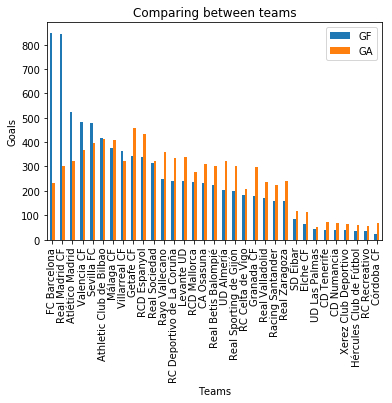

In [22]:
#comparing between fc barcelona and real madrid GF & GA 
goals_viz = goals_df
goals_viz.plot.bar(y=['GF', 'GA'])
plt.title('Comparing between teams')
plt.xlabel('Teams')
plt.ylabel('Goals');

### Taking only FCB and RM: 

In [23]:
# print only FCB and RM 
goals_df.head(2)

,GF,GA,GD
FC Barcelona,849,232,617
Real Madrid CF,843,304,539


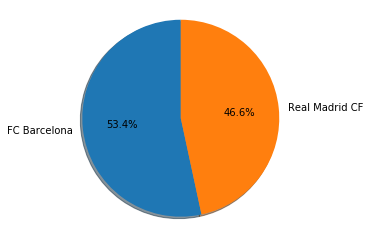

In [24]:
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_features.html
# ploting the goal differences only in pie chart 
goals_fc_rm = goals_df.head(2) 
labels = 'FC Barcelona', 'Real Madrid CF'
sizes = goals_fc_rm['GD'] 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal') 
plt.show() 

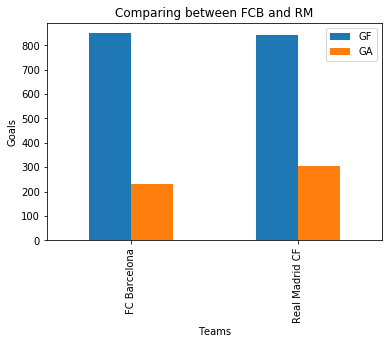

In [25]:
#comparing between fc barcelona and real madrid GF & GA 
goals_fc_rm = goals_df.head(2) 
goals_fc_rm.plot( y=["GF", "GA"], kind="bar")
plt.title('Comparing between FCB and RM')
plt.xlabel('Teams')
plt.ylabel('Goals');

### The data shows that FC Barcelona is better than Real Madrid in LaLiga between 2008 until 2016 with higher Goal differences, also it shows that the two teams have a much powerful forward players. 

# Conclusion: 
### The data has shown that FC Barcelona is the best team in the LaLiga through the seasons 2008-2016 in points, goals and goal differences and thats mostly because the team is stable and has good players in all positions. Also i have noticed that Barcelona and Real Madrid are competing each other for a long time ago specially between Messi who plays with FCB and Ronaldo who played with RM during 2009-2018. 

# Cleaning: 

### The data i worked with is clean but i did some few steps to clean and work with the missing data 

## Checking if there's any missing data:

In [26]:
# check if there's any missing data 
laliga.isnull().sum()

id                     0
country_id             0
league_id              0
season                 0
stage                  0
date                   0
match_api_id           0
home_team_api_id       0
away_team_api_id       0
home_team_goal         0
away_team_goal         0
home_player_X1         0
home_player_X2         0
home_player_X3         0
home_player_X4         0
home_player_X5         0
home_player_X6         0
home_player_X7         0
home_player_X8         0
home_player_X9         0
home_player_X10        0
home_player_X11        0
away_player_X1         0
away_player_X2         0
away_player_X3         0
away_player_X4         0
away_player_X5         0
away_player_X6         0
away_player_X7         0
away_player_X8         0
                    ... 
B365H                  1
B365D                  1
B365A                  1
BWH                    1
BWD                    1
BWA                    1
IWH                    4
IWD                    4
IWA                    4


Drop the missing attributes: 

In [27]:
# drop some columns with missing data that i wont use 
laliga.drop(['B365H', 'B365D','B365A','BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'], axis=1, inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Find the mean for some columns and fill it in with it: 

In [28]:
# find the mean for some columns and fill in the missing data 
mean = laliga.mean()
laliga.fillna(mean, inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
